In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory_dataset = '/content/drive/My Drive/Data Science Projects/Potato Disease Classification/Dataset'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_dataset,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

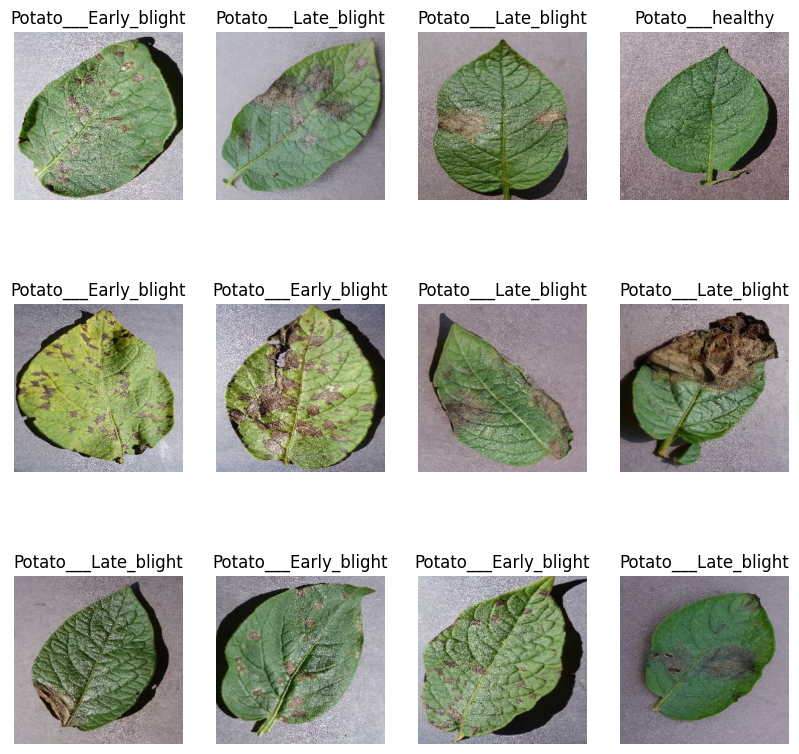

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[i]])

In [ ]:
def get_dataset_partitions(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed = 12)
  train_ds_size = int(ds_size * train_split)
  train_ds = ds.take(train_ds_size)
  val_ds_size = int(ds_size * val_split)
  val_ds = ds.skip(train_ds_size).take(val_ds_size)
  test_ds = ds.skip(train_ds_size).skip(val_ds_size)
  return train_ds,val_ds,test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## ***Rescale and Resize***

In [ ]:
rescale_and_resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1./255),
])

## ***Data Augmentation***

In [ ]:
data_augmentaion = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3
model = tf.keras.Sequential([
    rescale_and_resize,
    data_augmentaion,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

In [ ]:
model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 30s 132ms/step - loss: 0.8959 - accuracy: 0.4948 - val_loss: 0.8094 - val_accuracy: 0.5521
Epoch 2/50
54/54 [==============================] - 4s 65ms/step - loss: 0.5264 - accuracy: 0.7564 - val_loss: 0.6246 - val_accuracy: 0.7604
Epoch 3/50
54/54 [==============================] - 4s 67ms/step - loss: 0.4085 - accuracy: 0.8223 - val_loss: 0.3984 - val_accuracy: 0.8854
Epoch 4/50
54/54 [==============================] - 4s 66ms/step - loss: 0.3526 - accuracy: 0.8513 - val_loss: 0.3004 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 4s 65ms/step - loss: 0.3341 - accuracy: 0.8727 - val_loss: 0.3324 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 4s 66ms/step - loss: 0.3612 - accuracy: 0.8542 - val_loss: 0.4743 - val_accuracy: 0.8021
Epoch 7/50
54/54 [==============================] - 4s 83ms/step - loss: 0.3095 - accuracy: 0.8727 - val_loss: 0.3490 - val_accuracy: 0.8542
Epoch 8/50


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 28ms/step - loss: 0.0350 - accuracy: 0.9922


In [ ]:
scores

[0.03501585125923157, 0.9921875]

## ***Plotting Accuracy and Loss Curves***

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['loss'][:5]

[0.8959002494812012,
 0.5263507962226868,
 0.4084865152835846,
 0.3526208996772766,
 0.3341229259967804]

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

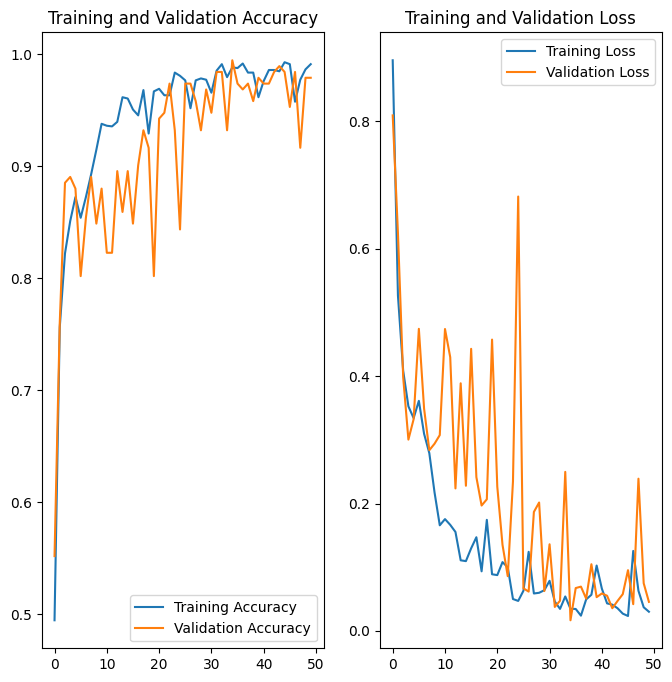

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), train_acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), train_loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image to Predict
Actual Label : Potato___Late_blight
1/1 [==============================] - 0s 33ms/step
Predicted Label : Potato___Late_blight


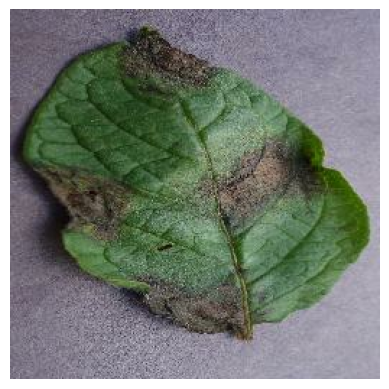

In [ ]:
import numpy as np
for images_batch, label_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()
  print("First Image to Predict")
  plt.imshow(first_image)
  plt.axis('off')
  print(f'Actual Label : {class_names[first_label]}')
  batch_prediction = model.predict(images_batch)
  print(f'Predicted Label : {class_names[np.argmax(batch_prediction[0])]}')

In [ ]:
def predict_category(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence = predict_category(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f'Actual Class : {actual_class} \n Predicted Class : {predicted_class} \n Confidence : {confidence}')
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

## ***Saving The Model***

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/My Drive/Data Science Projects/Potato Disease Classification/models") + [0]])+1
model.save(f"/content/drive/My Drive/Data Science Projects/Potato Disease Classification/models/{model_version}")